In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

In [2]:
#Reading the data file from github
data=pd.read_csv('https://raw.githubusercontent.com/imtiazBDSgit/PythonScripts/master/NEFT_RBI.csv')
data['DATE'] = pd.to_datetime(data['DATE'])
data.head()

,TYPE,BANK,DEBITS_TRANSACTIONS,DEBIT_AMOUNT,CREDIT_TRANSACTIONS,CREDIT_AMOUNT,DATE
0,COOPERATIVE,ABHYUDAYA CO-OP BANK LTD,37408,2149.64,97422,3470.74,2016-05-01
1,COOPERATIVE,ABHYUDAYA CO-OP BANK LTD,37810,2418.89,101211,3619.33,2016-06-01
2,COOPERATIVE,ABHYUDAYA CO-OP BANK LTD,38030,2309.36,104050,3618.13,2016-07-01
3,COOPERATIVE,ABHYUDAYA CO-OP BANK LTD,40801,2313.26,110826,3789.99,2016-08-01
4,COOPERATIVE,ABHYUDAYA CO-OP BANK LTD,39431,2233.91,107036,3650.23,2016-09-01


### Considering only Private Sector Banks and aggregating over the years transaction


In [3]:
data_private=data[data['TYPE']=='PRIVATE_SECTOR']
data_private=data_private.set_index('DATE')
data_private=data_private.drop(['BANK'])
data_private=data_private.groupby(data_private.index).sum()
data_private=data_private.reset_index()
data_private=data_private.set_index('DATE')

### Private Sector Bank DEBIT TRANSACTIONS

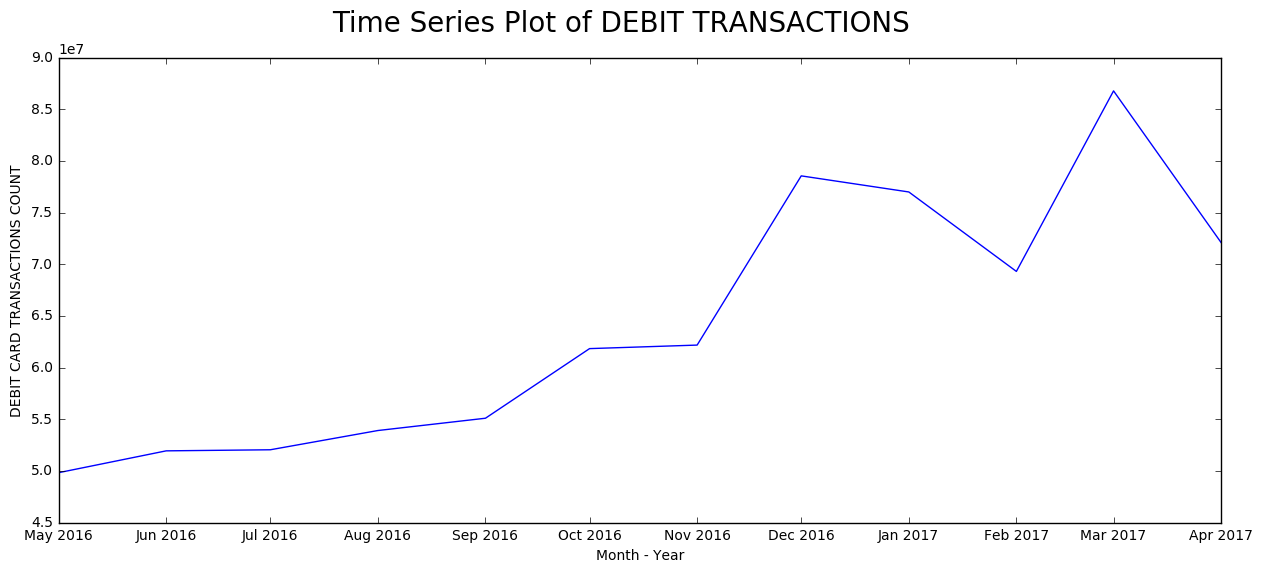

In [4]:
ts = data_private['DEBITS_TRANSACTIONS']
fig =plt.figure()
plt.plot(ts)
fig.suptitle('Time Series Plot of DEBIT TRANSACTIONS', fontsize=20)
plt.xlabel('Month - Year')
plt.ylabel('DEBIT CARD TRANSACTIONS COUNT')

### plotting the moving average quarterly

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()
  app.launch_new_instance()


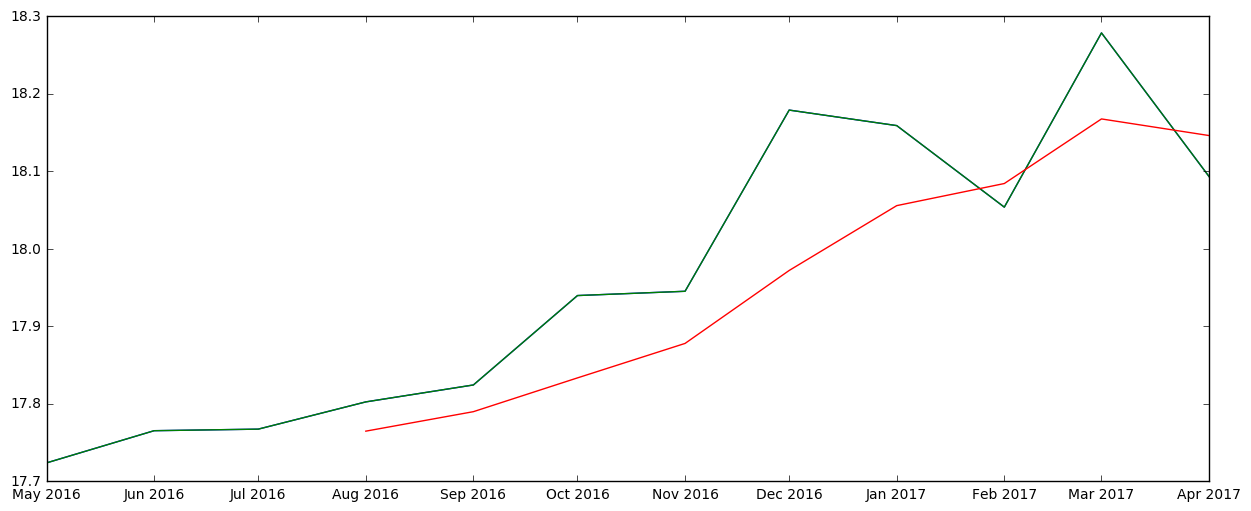

In [5]:
ts_log = np.log(ts)
plt.plot(ts_log)
moving_avg = pd.rolling_mean(ts_log,4)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

### Smoothing to apply forecasting model

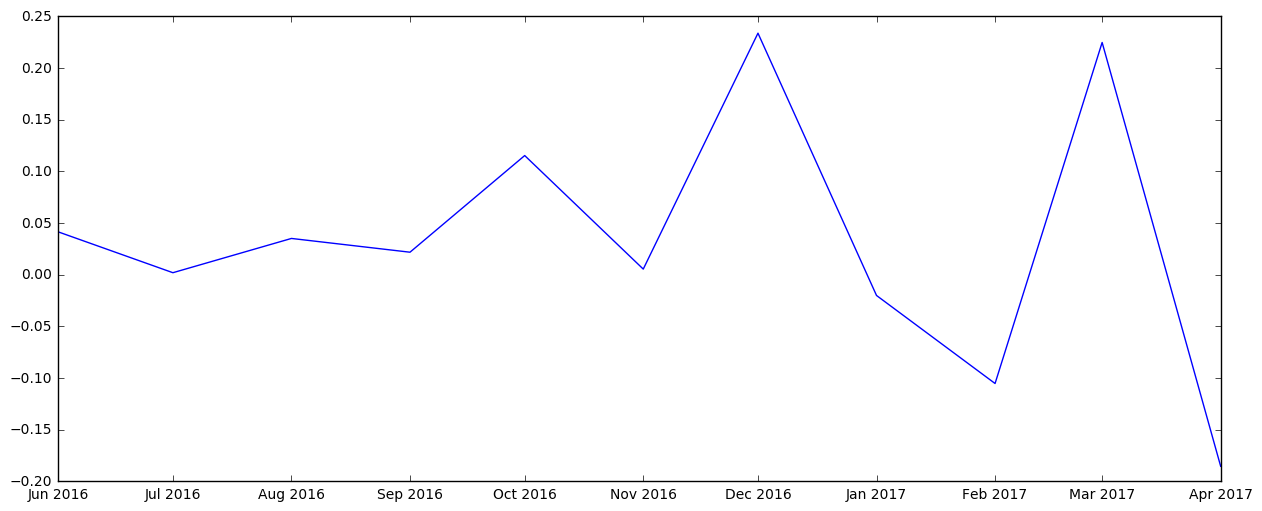

In [6]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)


### Dropping the NA values from preventing calculation errors

In [7]:
ts_log_diff.dropna(inplace=True)

### Calculating ACF and PACF Values

In [8]:
lag_acf = acf(ts_log_diff, nlags=4)
lag_pacf = pacf(ts_log_diff, nlags=4, method='ols')

### Plot ACF and PACF

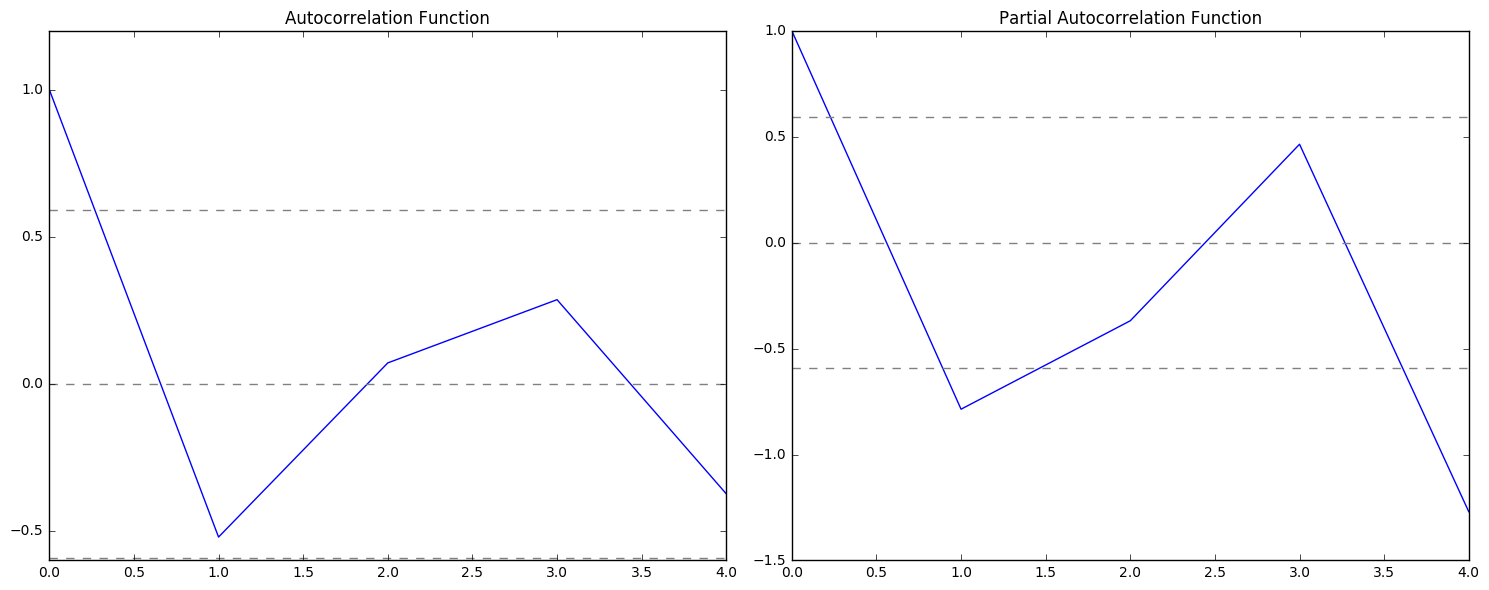

In [9]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

##### The graph cuts the upper confidence levels at equal to 1 so lets take p and q values to be 1 for Arima Modelling

### Arima Modelling 

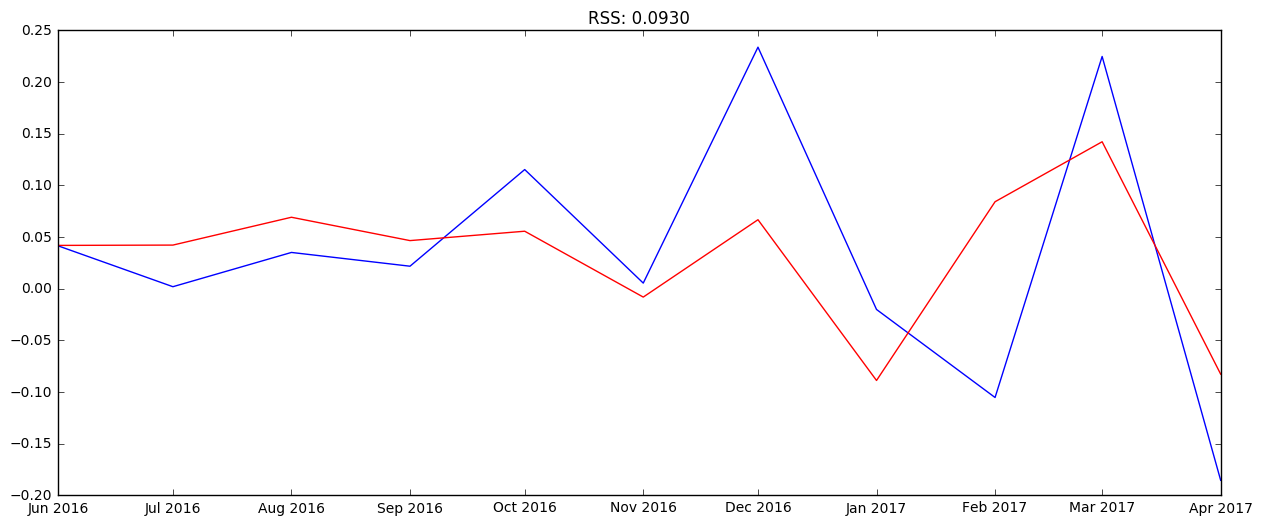

In [10]:
model = ARIMA(ts_log, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))


### Converting the predictions back to normal scale

In [11]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

DATE
2016-06-01    0.041979
2016-07-01    0.042281
2016-08-01    0.069219
2016-09-01    0.046625
2016-10-01    0.055702
dtype: float64
DATE
2016-06-01    0.041979
2016-07-01    0.084260
2016-08-01    0.153479
2016-09-01    0.200104
2016-10-01    0.255806
dtype: float64


DATE
2016-05-01    17.723946
2016-06-01    17.765925
2016-07-01    17.808206
2016-08-01    17.877425
2016-09-01    17.924051
dtype: float64

### Plotting the Arima Model curve with the exact values.

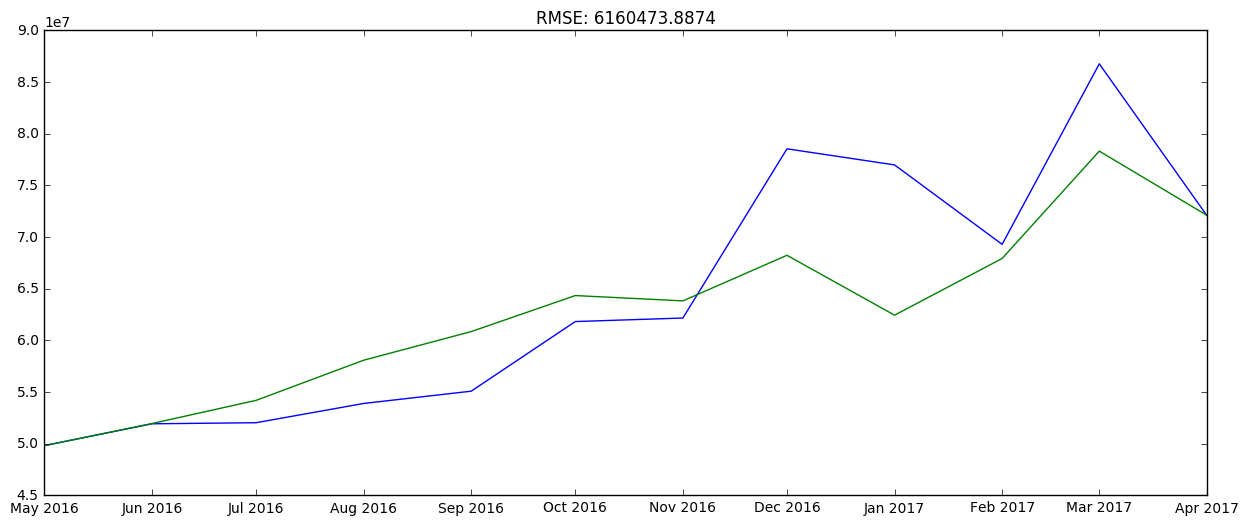

In [12]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))
